<a href="https://colab.research.google.com/github/ykato27/AutoEncorder/blob/main/ae_mnist_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders (using MLP and CNN) for (fashion) MNIST

Code based on 
https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. DNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [2]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import os
import time

import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import PIL
import seaborn as sns
import sklearn
from IPython import display

sns.set(style="ticks", color_codes=True)

import pandas as pd

pd.set_option("precision", 2)  # 2 decimal places
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 100)  # wide windows

In [3]:
np.random.seed(0)

FASHION = True

if FASHION:
    (train_images, train_labels), (
        test_images,
        test_labels,
    ) = keras.datasets.fashion_mnist.load_data()
    class_names = [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]
else:
    (train_images, train_labels), (
        test_images,
        test_labels,
    ) = keras.datasets.mnist.load_data()
    class_names = [str(x) for x in range(10)]
train_images = train_images / 255.0
test_images = test_images / 255.0

print(np.shape(train_images))
print(np.shape(test_images))
# (60000, 28, 28)
# (10000, 28, 28)

# Partition training into train and valid
X_train_full = train_images
y_train_full = train_labels
X_test = test_images
y_test = test_labels
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [5]:
# Visualize 2d manifold from  encodings using tSNE

import matplotlib
from sklearn.manifold import TSNE


def plot_embeddings_tsne(X_data, y_data, encodings):
    np.random.seed(42)
    tsne = TSNE()
    X_data_2D = tsne.fit_transform(encodings)
    X_data_2D = (X_data_2D - X_data_2D.min()) / (X_data_2D.max() - X_data_2D.min())

    # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.tab10
    plt.scatter(X_data_2D[:, 0], X_data_2D[:, 1], c=y_data, s=10, cmap=cmap)
    image_positions = np.array([[1.0, 1.0]])
    for index, position in enumerate(X_data_2D):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > 0.02:  # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = matplotlib.offsetbox.AnnotationBbox(
                matplotlib.offsetbox.OffsetImage(X_data[index], cmap="binary"),
                position,
                bboxprops={"edgecolor": cmap(y_data[index]), "lw": 2},
            )
            plt.gca().add_artist(imagebox)
    plt.axis("off")

# Standard AE

## MLP

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),
    ]
)
stacked_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.5),
    metrics=[rounded_accuracy],
)
history = stacked_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3171 - val_rounded_accuracy: 0.8995
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3020 - val_rounded_accuracy: 0.9201
Epoch 3/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2986 - val_rounded_accuracy: 0.9198
Epoch 4/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2920 - val_rounded_accuracy: 0.9284


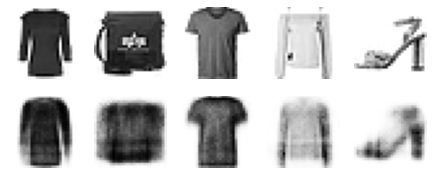

In [7]:
show_reconstructions(stacked_ae)

(5000, 30)


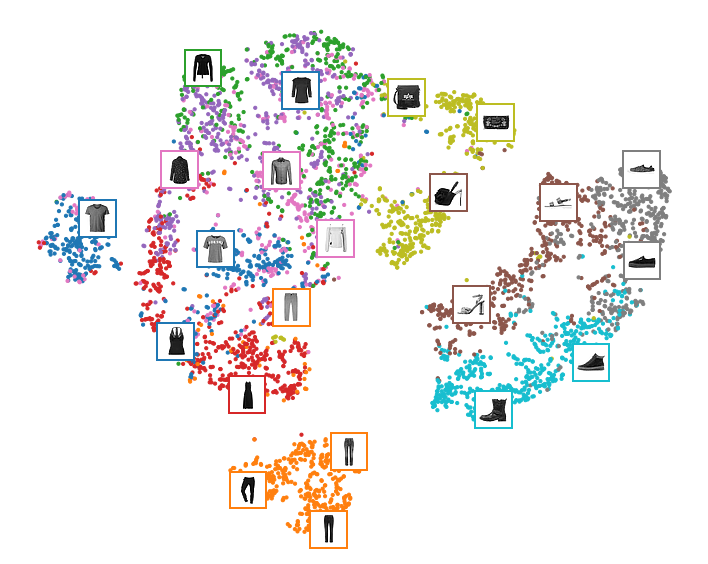

In [8]:
Z = stacked_encoder.predict(X_valid)
print(Z.shape)
plot_embeddings_tsne(X_valid, y_valid, Z)
plt.tight_layout()
plt.savefig("ae-mlp-fashion-tsne.pdf")
plt.show()

## CNN

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential(
    [
        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
    ]
)
conv_decoder = keras.models.Sequential(
    [
        keras.layers.Conv2DTranspose(
            32,
            kernel_size=3,
            strides=2,
            padding="VALID",
            activation="selu",
            input_shape=[3, 3, 64],
        ),
        keras.layers.Conv2DTranspose(
            16, kernel_size=3, strides=2, padding="SAME", activation="selu"
        ),
        keras.layers.Conv2DTranspose(
            1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"
        ),
        keras.layers.Reshape([28, 28]),
    ]
)
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.0),
    metrics=[rounded_accuracy],
)
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
1719/1719 [==============================] - 41s 7ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2843 - val_rounded_accuracy: 0.9298
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2756 - rounded_accuracy: 0.9414 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2686 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2664 - rounded_accuracy: 0.9510 - val_loss: 0.2671 - val_rounded_accuracy: 0.9508


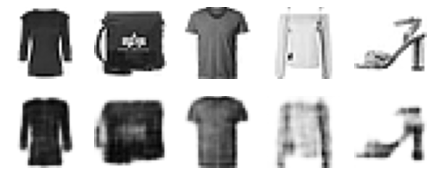

In [10]:
show_reconstructions(conv_ae)

(5000, 3, 3, 64)
(5000, 576)


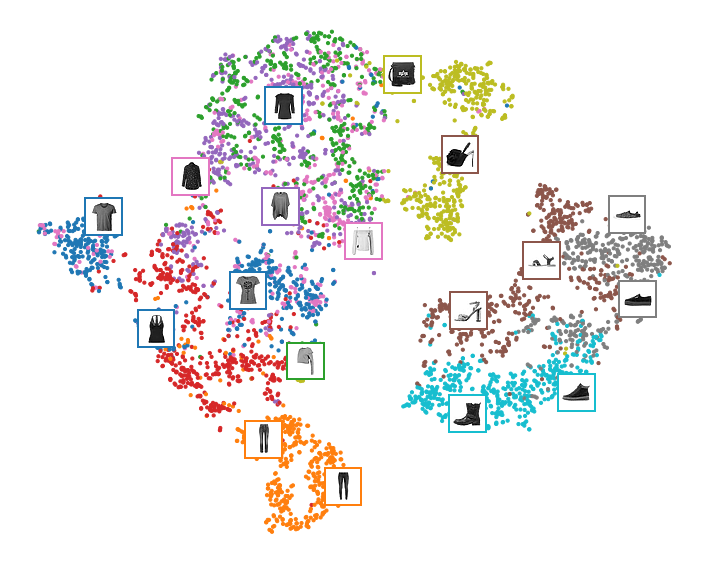

In [11]:
Z = conv_encoder.predict(X_valid)
print(Z.shape)
N = Z.shape[0]
ZZ = np.reshape(Z, (N, -1))
print(ZZ.shape)


plot_embeddings_tsne(X_valid, y_valid, ZZ)
plt.tight_layout()
plt.savefig("ae-conv-fashion-tsne.pdf")
plt.show()

# Denoising

## Gaussian noise

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3509 - rounded_accuracy: 0.8766 - val_loss: 0.3182 - val_rounded_accuracy: 0.9036
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3121 - rounded_accuracy: 0.9097 - val_loss: 0.3087 - val_rounded_accuracy: 0.9156
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3057 - rounded_accuracy: 0.9152 - val_loss: 0.3035 - val_rounded_accuracy: 0.9191
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3021 - rounded_accuracy: 0.9183 - val_loss: 0.2999 - val_rounded_accuracy: 0.9207
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2992 - rounded_accuracy: 0.9209 - val_loss: 0.2968 - val_rounded_accuracy: 0.9252
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2969 - rounded_accuracy: 0.9229 - val_loss: 0.2947 - val_rounded_accuracy: 0.9272
Epoch 7/10
1719/1719 [==================

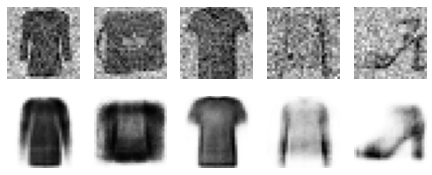

In [12]:
# Using Gaussian noise

tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.GaussianNoise(0.2),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),
    ]
)
denoising_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.0),
    metrics=[rounded_accuracy],
)
history = denoising_ae.fit(
    X_train, X_train, epochs=10, validation_data=(X_valid, X_valid)
)

tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
# save_fig("ae-denoising-gaussian.pdf")
plt.show()

## Bernoulli dropout noise

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9040
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9172
Epoch 7/10
1719/1719 [==================

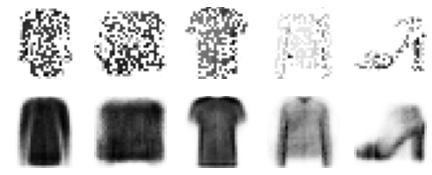

In [13]:
# Dropout version


tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),
    ]
)
dropout_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.0),
    metrics=[rounded_accuracy],
)
history = dropout_ae.fit(
    X_train, X_train, epochs=10, validation_data=(X_valid, X_valid)
)

tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
# save_fig("ae-denoising-dropout.pdf")

# Sparse

## Vanilla AE

In [14]:
# Simple AE with sigmoid activations on the bottleneck

tf.random.set_seed(42)
np.random.seed(42)

Nhidden = 300  # Geron uses 30 for the simple AE, 300 for the regularized ones
simple_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(Nhidden, activation="sigmoid"),
    ]
)
simple_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[Nhidden]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.0),
    metrics=[rounded_accuracy],
)
history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3873 - rounded_accuracy: 0.8377 - val_loss: 0.3439 - val_rounded_accuracy: 0.8858
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3260 - rounded_accuracy: 0.8988 - val_loss: 0.3210 - val_rounded_accuracy: 0.9051
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3152 - rounded_accuracy: 0.9075 - val_loss: 0.3139 - val_rounded_accuracy: 0.9094
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3096 - rounded_accuracy: 0.9122 - val_loss: 0.3091 - val_rounded_accuracy: 0.9142
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3055 - rounded_accuracy: 0.9156 - val_loss: 0.3054 - val_rounded_accuracy: 0.9171
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3023 - rounded_accuracy: 0.9183 - val_loss: 0.3028 - val_rounded_accuracy: 0.9192
Epoch 7/10
1719/1719 [==================

In [15]:
# To visualize statistics of the hidden units


def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths * 0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(
            lambda y, position: "{}%".format(int(np.round(100 * y)))
        )
    )
    ax.grid(True)


def plot_activations_histogram2(encoder, height=1, n_bins=10, fname_base=""):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, ax1 = plt.subplots()
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot(
        [mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean)
    )
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    fname_act = "{}-act.pdf".format(fname_base)
    # save_fig(fname_act)
    plt.show()

    fig, ax2 = plt.subplots()
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot(
        [mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean)
    )
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])
    fname_act = "{}-neurons.pdf".format(fname_base)
    # save_fig(fname_act)
    plt.show()


def plot_activations_heatmap(encoder, N=100):
    X = encoder(X_valid).numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(X[:N, :])

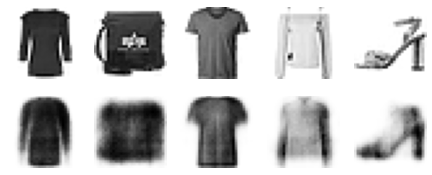

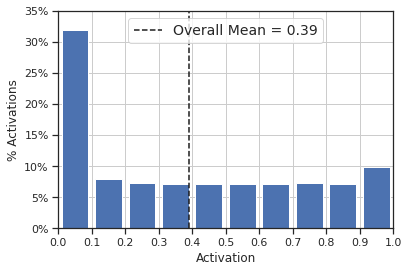

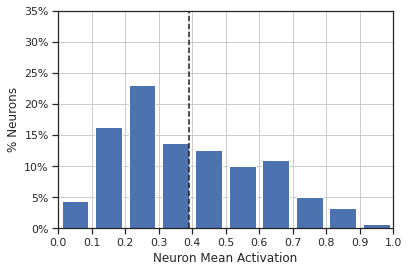

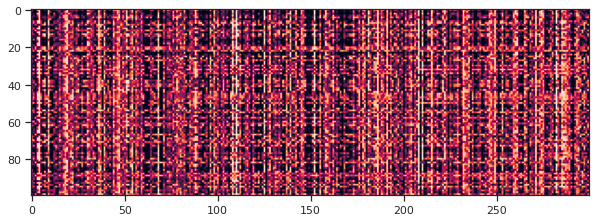

In [16]:
show_reconstructions(simple_ae)
plot_activations_histogram2(simple_encoder, height=0.35, fname_base="ae-sparse-noreg")
plot_activations_heatmap(simple_encoder)
# save_fig("ae-sparse-noreg-heatmap.pdf")
plt.show()

## L1 regularizer on activations

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

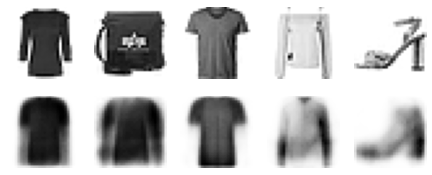

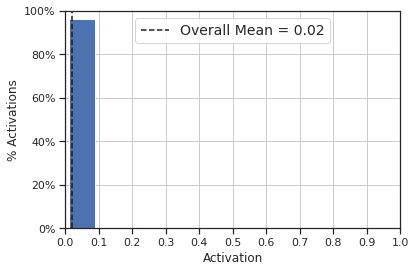

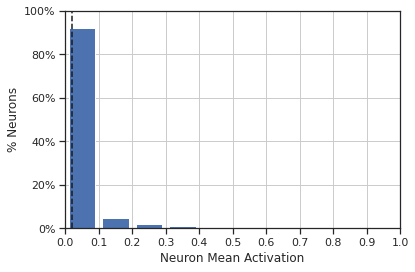

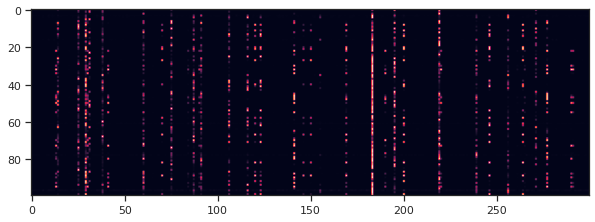

In [17]:
# Add L1 regularizer
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(Nhidden, activation="sigmoid"),
        keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
        # activity_regularizer=keras.regularizers.l1(1e-3)
        # to the previous layer.
    ]
)
sparse_l1_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[Nhidden]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.0),
    metrics=[rounded_accuracy],
)
history = sparse_l1_ae.fit(
    X_train, X_train, epochs=10, validation_data=(X_valid, X_valid)
)

show_reconstructions(sparse_l1_ae)
plot_activations_histogram2(sparse_l1_encoder, fname_base="ae-sparse-L1reg")
plot_activations_heatmap(sparse_l1_encoder)
# save_fig("ae-sparse-L1reg-heatmap.pdf")
plt.show()

## KL regularizer on activations

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

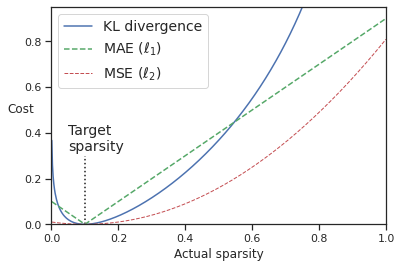

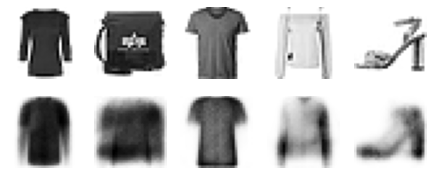

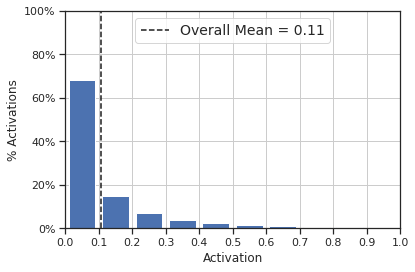

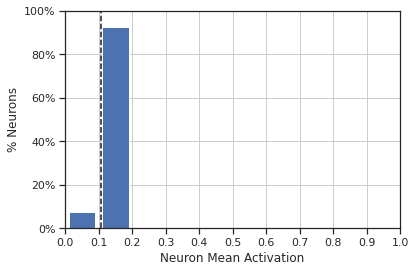

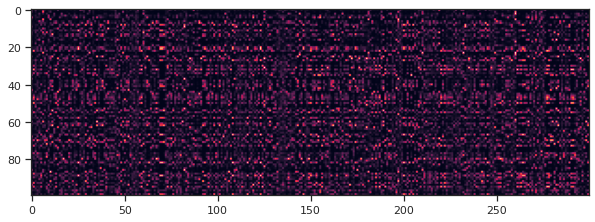

In [18]:
# KL method
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
# save_fig("ae-sparse-kl-loss")

K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence


class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities)
            + kl_divergence(1.0 - self.target, 1.0 - mean_activities)
        )


tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(Nhidden, activation="sigmoid", activity_regularizer=kld_reg),
    ]
)
sparse_kl_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[Nhidden]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.0),
    metrics=[rounded_accuracy],
)
history = sparse_kl_ae.fit(
    X_train, X_train, epochs=10, validation_data=(X_valid, X_valid)
)

show_reconstructions(sparse_kl_ae)
plot_activations_histogram2(sparse_kl_encoder, fname_base="ae-sparse-KLreg")
plot_activations_heatmap(sparse_kl_encoder)
# save_fig("ae-sparse-KLreg-heatmap.pdf")
plt.show()